In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import dateutil.parser as dparser

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
columns_m = inspector.get_columns('Measurement')
for c in columns_m:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [11]:
one_year_ago = dparser.parse(last_date[0],fuzzy=True) - dt.timedelta(days=365)
one_year_ago.year

2016

In [12]:
# Calculate the date one year from the last date in data set.
one_year_ago = dparser.parse(last_date[0],fuzzy=True) - dt.timedelta(days=365)
one_year_ago
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()


# Perform a query to retrieve the data and precipitation scores
all_scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_data, columns=["Date","Precipitation"]).sort_values('Date')
prcp_df.set_index("Date", inplace=True)


# prcp_df = prcp_df.sort_index(ascending=True)
# prcp_df.sort_values(by = 'Date', inplace = True)

prcp_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


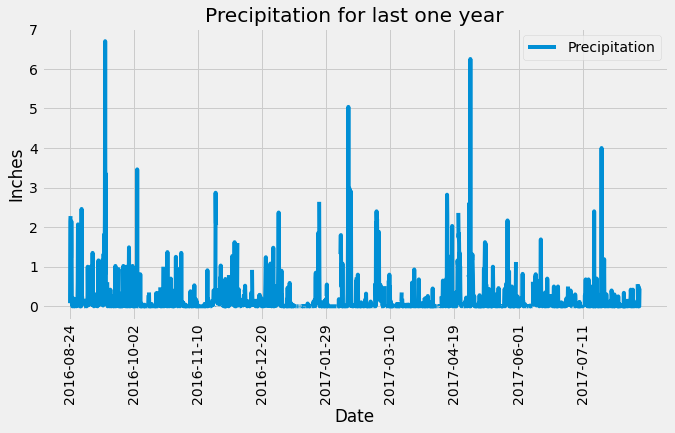

In [13]:
# Fixing X-ticks 
x = np.arange(0, len(prcp_df), 250)
x_ticks = []
date_list = list(prcp_df.index)
for i in range(0,len(date_list),250):
    x_ticks.append(date_list[i])
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation for last one year", figsize=(10,5))
plt.legend(loc='best')
plt.xticks(x, x_ticks,rotation=90)
plt.ylabel("Inches")
plt.savefig("Images/precipitation.png")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [16]:
station_count2 = session.query(Station.station).distinct().count()
station_count2

9

In [17]:
columns_s = inspector.get_columns('station')
for c in columns_s:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
station_data = session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_df = pd.DataFrame(station_data, columns=["id", "station", "name", "latitude", "longitude", "elevation"])
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
most_active_stations[0][0]

'USC00519281'

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_max_avg_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_stations[0][0]).all()
# min_max_avg_temp
print(f'Minimum temperature: {min_max_avg_temp[0][0]}')
print(f'Maximum temperature: {min_max_avg_temp[0][1]}')
print(f'Average temperature: {round(min_max_avg_temp[0][2],2)}')

Minimum temperature: 54.0
Maximum temperature: 85.0
Average temperature: 71.66


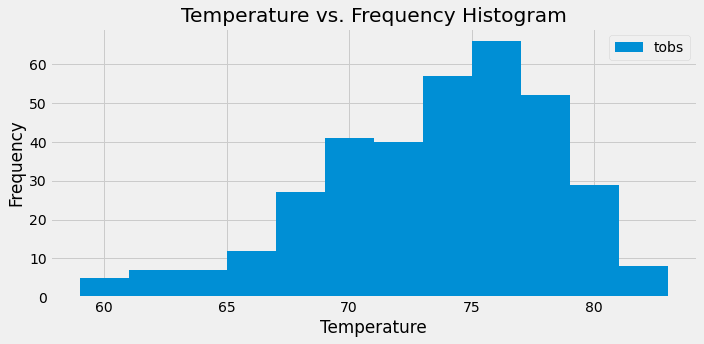

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == most_active_stations[0][0]).\
    order_by(Measurement.date).all()
# Save the Query Results as a Pandas DataFrame
tobs_data_df = pd.DataFrame(tobs_data, columns=["tobs"])

# Plot the Results as a Histogram with `bins=12`
tobs_data_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(10,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Images/temperature_vs_frequency.png")
plt.show()

# Close session

In [23]:
# Close Session
session.close()